In [2]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from datetime import datetime

In [3]:
#Reading in the file
df = pd.read_csv("dataport-export_gas_oct2015-mar2016.csv")
df.tail()

,localminute,dataid,meter_value
1584818,2016-03-31 23:59:14.336743-05,2129,201726
1584819,2016-03-31 23:59:17.427165-05,2945,161232
1584820,2016-03-31 23:59:35.370782-05,9729,138146
1584821,2016-03-31 23:59:47.816286-05,5129,166488
1584822,2016-03-31 23:59:58.92308-05,484,114174


### Q1.1

In [4]:
#Each household should only have 1 meter, and thus 1 meter id per household. Finding num households
num_households = len(df["dataid"].unique())
display("The number of households is %s" %num_households)

'The number of households is 157'

### Q1.2

Generate hourly readings from the raw data. Select one month from the 6-month study interval and plot the hourly readings (time-series) for that month. Hint: You will have to decide what to do if there are no readings for a certain hour.

For this question, we selected the month of October

In [5]:
months = {'Oct':'-10-','Nov':'-11-','Dec':'-12-','Jan':'-01-','Feb':'-02-','Mar':'-03-',}
df2 = df[df['localminute'].str.contains(months['Oct'])]
df3 = df2.sort_values(by=['dataid', 'localminute'])
df3 = df3.reset_index(drop=True)

In [6]:
#make data look nicer for each house (1 reading per hour)
times = []
ids = df3['dataid'].nunique()
#current_id = df3['dataid'][0]

form = '%Y-%m-%d %H:%M:%S'
for i in range(len(df3)):
    time = datetime.strptime(df3['localminute'][i][:18], form)  
    times.append(time)

df3.index = times
df3 = df3.drop(columns = 'localminute')
df3

,dataid,meter_value
2015-10-01 00:14:04,35,93470
2015-10-01 00:42:03,35,93470
2015-10-01 02:02:03,35,93470
2015-10-01 02:12:03,35,93470
2015-10-01 02:20:03,35,93470
...,...,...
2015-10-31 19:34:01,9982,107064
2015-10-31 21:05:01,9982,107064
2015-10-31 21:31:00,9982,107064
2015-10-31 23:12:01,9982,107072


In [7]:
#run resampling by dataid
all_hourly_vals = pd.DataFrame()
running = 1
all_ids = sorted(df3['dataid'].unique())

for i in range(len(all_ids)):
    data = df3.loc[df3["dataid"] ==  all_ids[i]]
    meter_hourly = data.resample('H').max() #maybe take latest reading
    meter_hourly = meter_hourly.fillna(method='backfill')
    meter_hourly = meter_hourly.fillna(method='ffill')
    all_hourly_vals[all_ids[i]] = meter_hourly['meter_value'] - meter_hourly['meter_value'][0]
    all_hourly_vals = all_hourly_vals.fillna(method='backfill')
    all_hourly_vals = all_hourly_vals.fillna(method='ffill')
    #print(all_hourly_vals)
#all_hourly_values is a backfilled then frontfilled dataframe of hourly averaged meter values for every house in the month of October

In [8]:
all_hourly_vals['mean'] = all_hourly_vals.mean(axis=1)
all_hourly_vals['max'] = all_hourly_vals.max(axis=1)
all_hourly_vals['min'] = all_hourly_vals.min(axis=1)
all_hourly_vals

,35,44,77,94,114,187,222,252,370,483,...,9631,9639,9729,9766,9849,9956,9982,mean,max,min
2015-10-01 00:00:00,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2015-10-01 01:00:00,0.0,0.0,0.0,2,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.718310,28.0,0.0
2015-10-01 02:00:00,0.0,0.0,0.0,2,2.0,0.0,0.0,2.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.197183,28.0,0.0
2015-10-01 03:00:00,0.0,0.0,0.0,2,2.0,4.0,2.0,2.0,0.0,0.0,...,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.859155,28.0,0.0
2015-10-01 04:00:00,0.0,0.0,0.0,2,2.0,4.0,2.0,2.0,0.0,0.0,...,2.0,2.0,2.0,0.0,0.0,2.0,0.0,2.380282,28.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-31 19:00:00,976.0,826.0,698.0,970,1048.0,1412.0,6728.0,750.0,410.0,762.0,...,788.0,1052.0,758.0,1252.0,684.0,494.0,1118.0,915.521127,6728.0,0.0
2015-10-31 20:00:00,988.0,826.0,698.0,970,1048.0,1412.0,6728.0,752.0,410.0,762.0,...,788.0,1052.0,758.0,1252.0,684.0,494.0,1118.0,916.338028,6728.0,0.0
2015-10-31 21:00:00,988.0,826.0,706.0,970,1048.0,1412.0,6728.0,752.0,410.0,762.0,...,788.0,1052.0,758.0,1252.0,684.0,494.0,1118.0,918.338028,6728.0,0.0
2015-10-31 22:00:00,990.0,826.0,706.0,970,1048.0,1412.0,6728.0,752.0,412.0,762.0,...,788.0,1054.0,758.0,1252.0,684.0,494.0,1126.0,919.126761,6728.0,0.0


Text(0.5, 1.0, 'House 77 Cumulative Consumption')

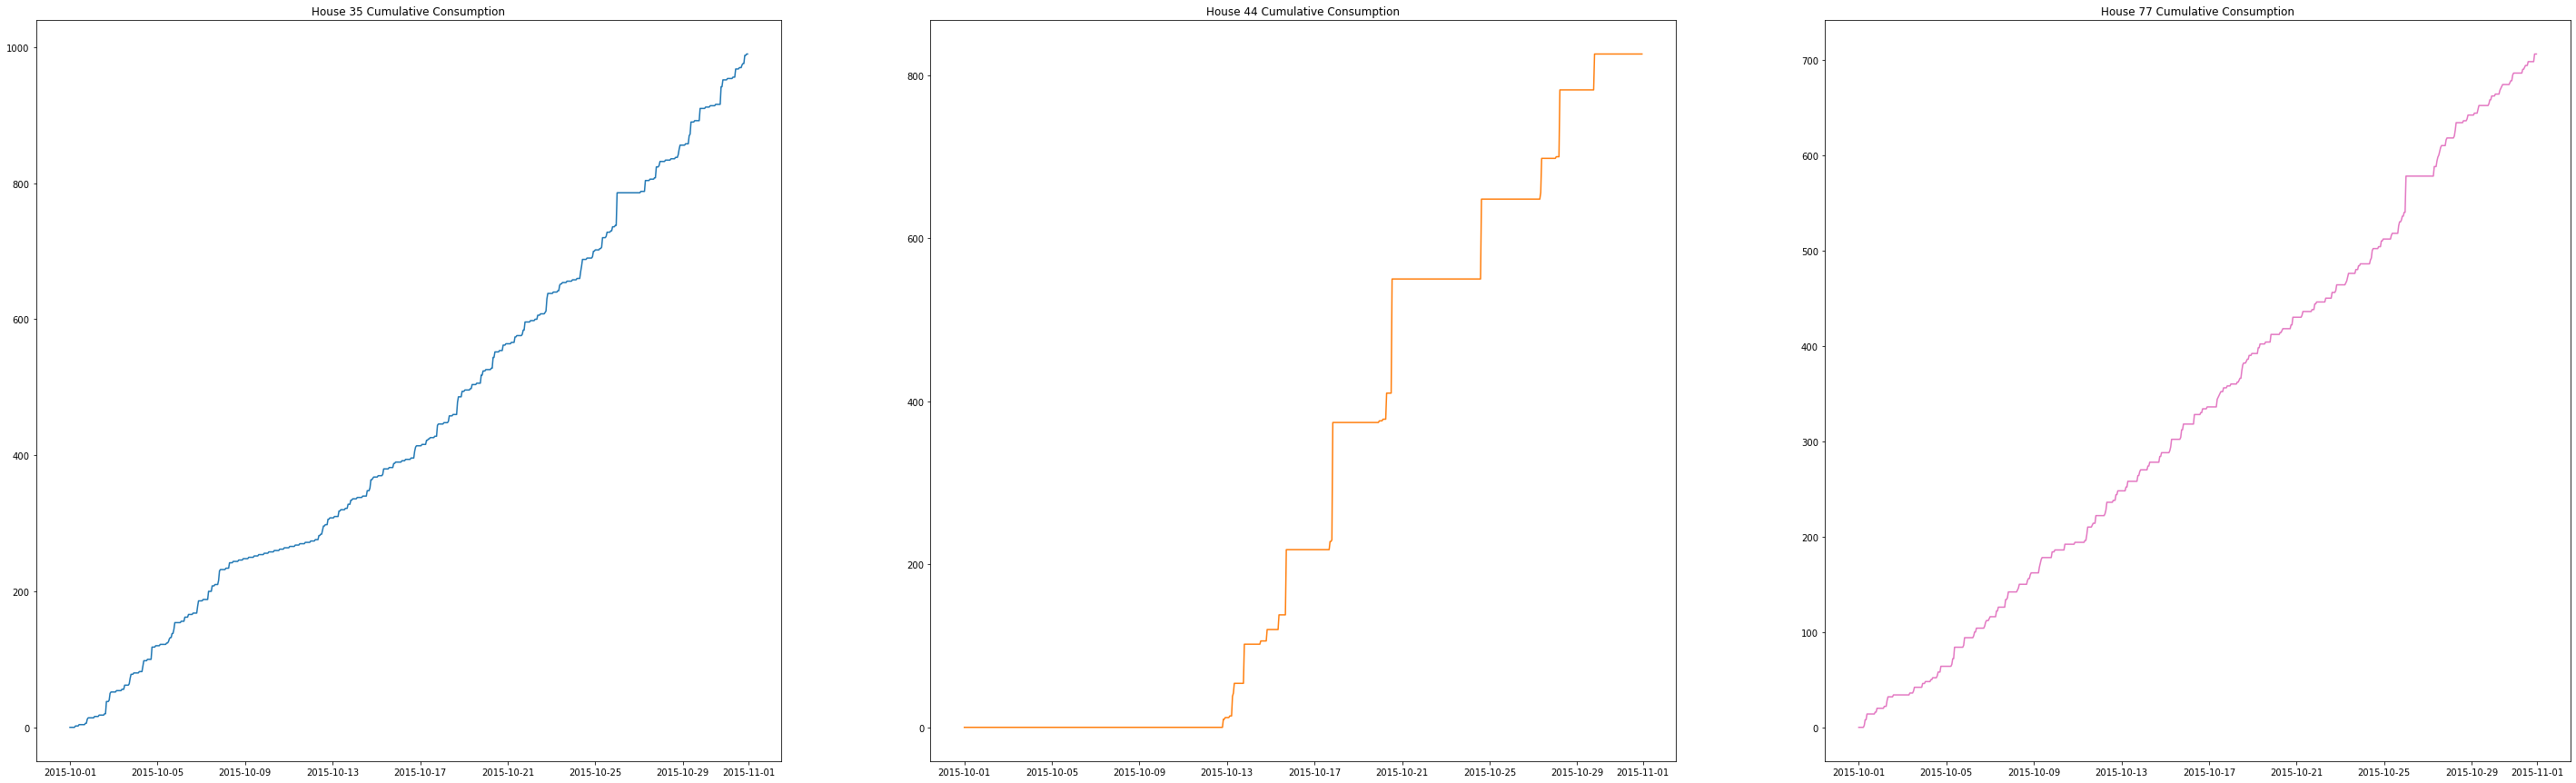

In [9]:
#print multiple values
house1 = all_hourly_vals[35]
house2 = all_hourly_vals[44]
house3 = all_hourly_vals[77]

fig, axs = plt.subplots(1, 3,figsize=(50,15))
axs[0].plot(all_hourly_vals.index, house1)
axs[0].set_title('House 35 Cumulative Consumption')
axs[1].plot(all_hourly_vals.index, house2, 'tab:orange')
axs[1].set_title('House 44 Cumulative Consumption')
axs[2].plot(all_hourly_vals.index, house3, 'tab:pink')
axs[2].set_title('House 77 Cumulative Consumption')

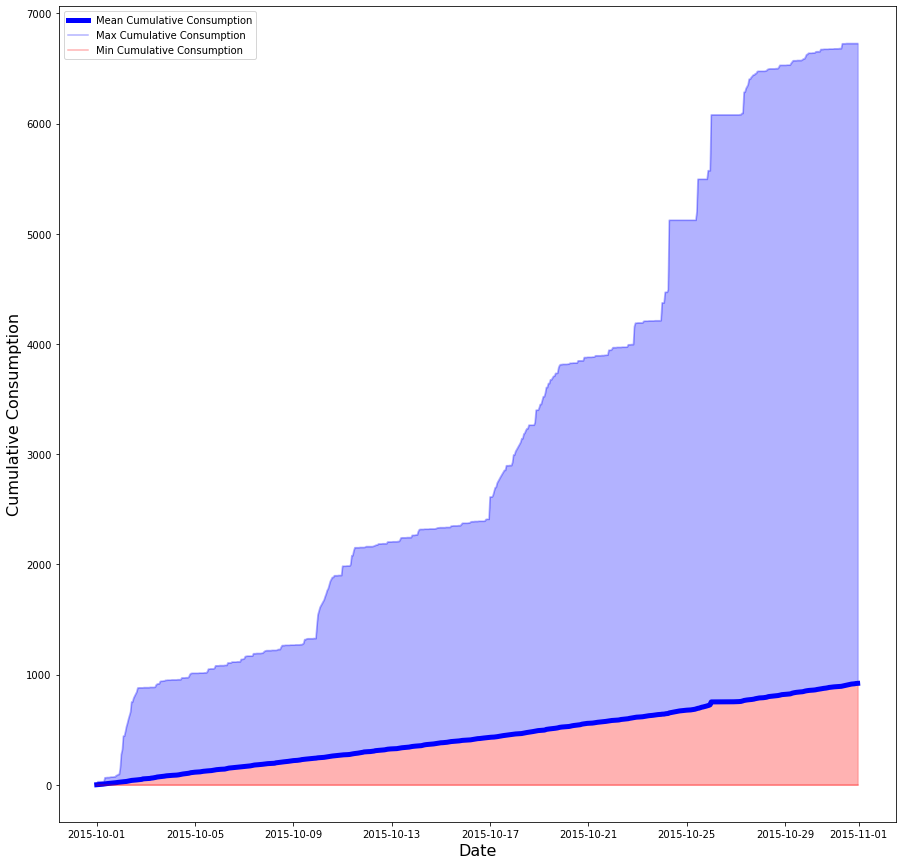

In [10]:
# Plot mean, max and min
houseMean = all_hourly_vals["mean"]
houseMax = all_hourly_vals["max"]
houseMin = all_hourly_vals["min"]

plt.figure(figsize=(15,15))
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Cumulative Consumption', fontsize = 16)
plt.plot(all_hourly_vals.index, houseMean, label = "Mean Cumulative Consumption", linewidth = 5, color='blue')
plt.plot(all_hourly_vals.index, houseMax, label = "Max Cumulative Consumption", color='blue', alpha = 0.3)
plt.plot(all_hourly_vals.index, houseMin, label = "Min Cumulative Consumption", color='red', alpha = 0.3)
plt.fill_between(all_hourly_vals.index, houseMean, houseMax, color='blue', alpha = 0.3)
plt.fill_between(all_hourly_vals.index, houseMean, houseMin, color='red', alpha = 0.3)
plt.legend()

### Q1.3
Intuitively, we expect that gas consumption from different homes to be correlated.
For example, many homes would experience higher consumption levels in the evening
when meals are cooked. For each home, find the top five homes with which it shows
the highest correlation.

In [11]:
#Formatting the dataframe so the time value is easier to work with
time_df = df.copy()
time_df.localminute = time_df.localminute.transform(lambda x: x[0:-3])
time_df.localminute = time_df.localminute.transform(lambda x: pd.Timestamp(x).value)

In [12]:
#Function to get correlation
from scipy import interpolate
from scipy import stats
def get_correlation(a, b):
    #Get time series of a and b
    timea,timeb = a.localminute, b.localminute
    #Max of two start times
    start_time = max(timea.iloc[0],timeb.iloc[0])
    #Min of two end times
    end_time = min(timea.iloc[-1],timeb.iloc[-1])
    #Creating interpolation
    time_series = np.linspace(start_time, end_time, max(len(a),len(b)))
    a_interp = interpolate.interp1d(timea,a.meter_value,fill_value="extrapolate")
    b_interp = interpolate.interp1d(timeb,b.meter_value,fill_value="extrapolate")
    a_new = a_interp(time_series)
    b_new = b_interp(time_series)
    #Get correlation
    return stats.pearsonr(a_new,b_new)

In [14]:
#Correlation "matrix" dataframe
households = df["dataid"].unique()
correlation_df = pd.DataFrame(columns=households, index = households)
for i in range(num_households):
    base_household = time_df[time_df.dataid == households[i]]
    for j in range(i+1,num_households):
        comparison_household = time_df[time_df.dataid == households[j]]
        corr, _ = get_correlation(base_household,comparison_household)
        correlation_df.loc[households[i],households[j]] = corr
        correlation_df.loc[households[j],households[i]] = corr

/home/weiern/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/weiern/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/weiern/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/weiern/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/weiern/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConsta

In [15]:
#Typecast to float for comparison
#Get top 5 correlations
correlation_df = correlation_df.astype("float64")
top5_correlations = pd.DataFrame(index=households, columns=[1,2,3,4,5])
for household in households:
    top5_correlations.loc[household] = correlation_df.nlargest(5,household).index.to_list()

In [17]:
top5_correlations.to_csv("cor.csv")
top5_correlations

,1,2,3,4,5
739,5814,661,7794,9295,3723
8890,3577,9052,4732,4031,3918
6910,1507,4373,2094,4732,5636
3635,8890,5814,661,3577,4356
1507,2094,5636,6910,4373,7741
...,...,...,...,...,...
7566,4874,44,9956,9639,9600
6673,3778,9982,94,9295,370
2814,6578,5403,2818,1801,9121
6101,6578,4874,6685,2814,7965
